In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/00


In [2]:
sig_df = pd.read_pickle('DNN_ips/SUSY_Mstop_190_mchi_7_5.pkl')
tt_df  = pd.read_pickle('DNN_ips/ttbar.pkl')
vv_df  = pd.read_pickle('DNN_ips/VV.pkl')
st_df  = pd.read_pickle('DNN_ips/Single_top.pkl')
sat_df = pd.read_pickle('DNN_ips/Single_antitop.pkl')

In [3]:
Pol_rw  = np.loadtxt('txt_files/SUSY_weights_mstop_175_mchi_7_5_Pol_minus1.txt')
Ecom_rw = np.loadtxt('txt_files/SUSY_Ecom_rw.txt')
Rw      = Pol_rw * Ecom_rw

In [4]:
# Standardize

sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [5]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:50000]
tt_df_train  = tt_df[1:40000]
st_df_train  = st_df[1:10000]
sat_df_train = sat_df[1:10000]
vv_df_train  = vv_df[1:1000]

In [6]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7fa4839e9d60>

In [8]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [     1      2      3 ... 110991 110992 110993] TEST: [     0      4      7 ... 110988 110990 110994]
TRAIN: [     0      4      7 ... 110988 110990 110994] TEST: [     1      2      3 ... 110991 110992 110993]


In [9]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [10]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

model = Sequential()
model.add(Dense(100, input_dim = 19  ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, input_dim = 100 ,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,201
Trainable params: 12,201
Non-trainable params: 0
_________________________________________________________________


2021-02-04 22:09:40.970476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-04 22:09:40.992993: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa489f89ed0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-04 22:09:40.993014: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [12]:
hist = model.fit(x_train, y_train, batch_size=50, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/1000
888/888 [==============================] - 1s 2ms/step - loss: 0.7025 - accuracy: 0.5240 - val_loss: 0.6902 - val_accuracy: 0.5354
Epoch 2/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6933 - accuracy: 0.5323 - val_loss: 0.6903 - val_accuracy: 0.5414
Epoch 3/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6899 - accuracy: 0.5430 - val_loss: 0.6893 - val_accuracy: 0.5456
Epoch 4/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6896 - accuracy: 0.5470 - val_loss: 0.6877 - val_accuracy: 0.5482
Epoch 5/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6887 - accuracy: 0.5465 - val_loss: 0.6885 - val_accuracy: 0.5486
Epoch 6/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6886 - accuracy: 0.5474 - val_loss: 0.6884 - val_accuracy: 0.5455
Epoch 7/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.6880 - accuracy: 0.5481 - val_loss: 0.6887 - val_accuracy:

888/888 [==============================] - 1s 1ms/step - loss: 0.2115 - accuracy: 0.9108 - val_loss: 0.1842 - val_accuracy: 0.9188
Epoch 58/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2160 - accuracy: 0.9084 - val_loss: 0.1752 - val_accuracy: 0.9256
Epoch 59/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2085 - accuracy: 0.9119 - val_loss: 0.1723 - val_accuracy: 0.9272
Epoch 60/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2102 - accuracy: 0.9111 - val_loss: 0.1782 - val_accuracy: 0.9156
Epoch 61/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2070 - accuracy: 0.9125 - val_loss: 0.1803 - val_accuracy: 0.9198
Epoch 62/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2080 - accuracy: 0.9124 - val_loss: 0.1612 - val_accuracy: 0.9332
Epoch 63/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.2054 - accuracy: 0.9117 - val_loss: 0.1650 - val_accuracy: 0.9286

888/888 [==============================] - 1s 1ms/step - loss: 0.1796 - accuracy: 0.9241 - val_loss: 0.1343 - val_accuracy: 0.9442
Epoch 114/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1729 - accuracy: 0.9284 - val_loss: 0.1396 - val_accuracy: 0.9395
Epoch 115/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1799 - accuracy: 0.9244 - val_loss: 0.1545 - val_accuracy: 0.9295
Epoch 116/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1766 - accuracy: 0.9258 - val_loss: 0.1327 - val_accuracy: 0.9431
Epoch 117/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1802 - accuracy: 0.9238 - val_loss: 0.1793 - val_accuracy: 0.9187
Epoch 118/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1745 - accuracy: 0.9254 - val_loss: 0.1396 - val_accuracy: 0.9388
Epoch 119/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1738 - accuracy: 0.9266 - val_loss: 0.1352 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1670 - accuracy: 0.9297 - val_loss: 0.1241 - val_accuracy: 0.9456
Epoch 170/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1637 - accuracy: 0.9307 - val_loss: 0.1328 - val_accuracy: 0.9418
Epoch 171/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1675 - accuracy: 0.9310 - val_loss: 0.1220 - val_accuracy: 0.9445
Epoch 172/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1625 - accuracy: 0.9309 - val_loss: 0.1331 - val_accuracy: 0.9413
Epoch 173/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1616 - accuracy: 0.9316 - val_loss: 0.1374 - val_accuracy: 0.9378
Epoch 174/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1668 - accuracy: 0.9298 - val_loss: 0.1279 - val_accuracy: 0.9440
Epoch 175/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1631 - accuracy: 0.9314 - val_loss: 0.1185 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1540 - accuracy: 0.9367 - val_loss: 0.1068 - val_accuracy: 0.9562
Epoch 226/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1514 - accuracy: 0.9366 - val_loss: 0.1262 - val_accuracy: 0.9468
Epoch 227/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1568 - accuracy: 0.9347 - val_loss: 0.1130 - val_accuracy: 0.9504
Epoch 228/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1569 - accuracy: 0.9344 - val_loss: 0.1184 - val_accuracy: 0.9488
Epoch 229/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1550 - accuracy: 0.9355 - val_loss: 0.1203 - val_accuracy: 0.9452
Epoch 230/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1586 - accuracy: 0.9338 - val_loss: 0.1088 - val_accuracy: 0.9541
Epoch 231/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1525 - accuracy: 0.9369 - val_loss: 0.1171 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1531 - accuracy: 0.9371 - val_loss: 0.1267 - val_accuracy: 0.9431
Epoch 282/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1475 - accuracy: 0.9390 - val_loss: 0.1069 - val_accuracy: 0.9552
Epoch 283/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1460 - accuracy: 0.9394 - val_loss: 0.1126 - val_accuracy: 0.9504
Epoch 284/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1471 - accuracy: 0.9390 - val_loss: 0.1122 - val_accuracy: 0.9512
Epoch 285/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1498 - accuracy: 0.9382 - val_loss: 0.1166 - val_accuracy: 0.9507
Epoch 286/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1488 - accuracy: 0.9378 - val_loss: 0.1624 - val_accuracy: 0.9309
Epoch 287/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1489 - accuracy: 0.9390 - val_loss: 0.1180 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1378 - accuracy: 0.9422 - val_loss: 0.1255 - val_accuracy: 0.9405
Epoch 338/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1430 - accuracy: 0.9402 - val_loss: 0.1926 - val_accuracy: 0.9235
Epoch 339/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1374 - accuracy: 0.9432 - val_loss: 0.1103 - val_accuracy: 0.9484
Epoch 340/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1445 - accuracy: 0.9390 - val_loss: 0.1029 - val_accuracy: 0.9541
Epoch 341/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1399 - accuracy: 0.9413 - val_loss: 0.0988 - val_accuracy: 0.9559
Epoch 342/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1415 - accuracy: 0.9413 - val_loss: 0.1117 - val_accuracy: 0.9517
Epoch 343/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1397 - accuracy: 0.9423 - val_loss: 0.1174 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1333 - accuracy: 0.9443 - val_loss: 0.1032 - val_accuracy: 0.9538
Epoch 394/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1359 - accuracy: 0.9433 - val_loss: 0.1156 - val_accuracy: 0.9470
Epoch 395/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1376 - accuracy: 0.9427 - val_loss: 0.1037 - val_accuracy: 0.9543
Epoch 396/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1385 - accuracy: 0.9416 - val_loss: 0.0997 - val_accuracy: 0.9562
Epoch 397/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1321 - accuracy: 0.9453 - val_loss: 0.1022 - val_accuracy: 0.9512
Epoch 398/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1355 - accuracy: 0.9437 - val_loss: 0.1090 - val_accuracy: 0.9489
Epoch 399/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1336 - accuracy: 0.9442 - val_loss: 0.1129 - val_accuracy: 

888/888 [==============================] - 1s 1ms/step - loss: 0.1296 - accuracy: 0.9463 - val_loss: 0.1265 - val_accuracy: 0.9434
Epoch 450/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1309 - accuracy: 0.9466 - val_loss: 0.1076 - val_accuracy: 0.9482
Epoch 451/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1300 - accuracy: 0.9459 - val_loss: 0.0945 - val_accuracy: 0.9573
Epoch 452/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1307 - accuracy: 0.9453 - val_loss: 0.1283 - val_accuracy: 0.9410
Epoch 453/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1304 - accuracy: 0.9451 - val_loss: 0.1051 - val_accuracy: 0.9537
Epoch 454/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1275 - accuracy: 0.9470 - val_loss: 0.1012 - val_accuracy: 0.9539
Epoch 455/1000
888/888 [==============================] - 1s 1ms/step - loss: 0.1316 - accuracy: 0.9455 - val_loss: 0.1145 - val_accuracy: 

In [75]:
# serialize model to JSON
model_json = model.to_json()
with open("Mstop_190_mchi_7_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Mstop_190_mchi_7_5.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss' , fontsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Training Error by Epoch', fontsize=15)
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=15)
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)

    plt.show()

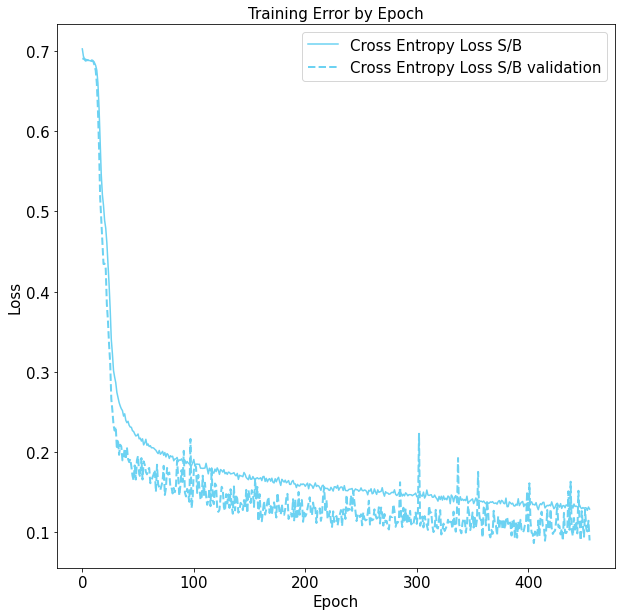

In [15]:
show_losses( [("Cross Entropy Loss S/B", hist)])

In [16]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [17]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

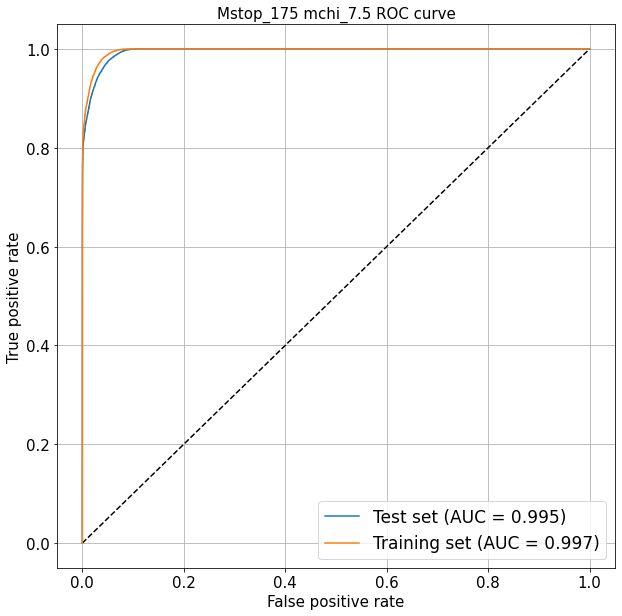

In [18]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_175 mchi_7.5 ROC curve', fontsize=15)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
plt.show()

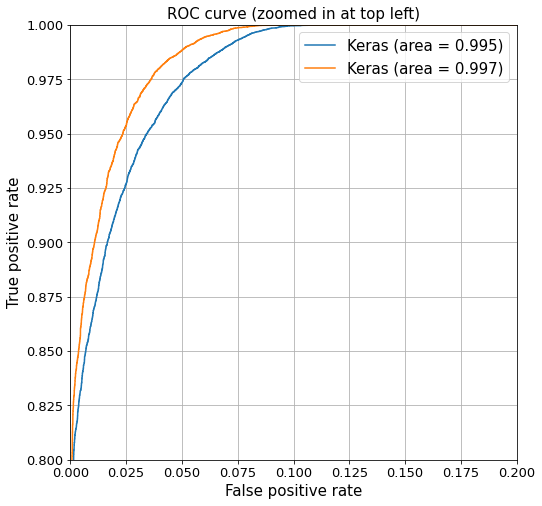

In [19]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(8,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_test , tpr_keras_test , label='Keras (area = {:.3f})'.format(auc_keras_test))
plt.plot(fpr_keras_train, tpr_keras_train, label='Keras (area = {:.3f})'.format(auc_keras_train))
plt.ylabel('True positive rate' , fontsize=15)
plt.xlabel('False positive rate', fontsize=15)
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis="x", labelsize=13)
plt.title('ROC curve (zoomed in at top left)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.grid()
plt.show()

In [20]:
tt_pred  = model.predict(tt_df[40000:]) 
st_pred  = model.predict(st_df[10000:]) 
sat_pred = model.predict(sat_df[10000:]) 
vv_pred  = model.predict(vv_df[1000:]) 
si_pred  = model.predict(sig_df[50000:])

In [21]:
st_list = [st_pred, sat_pred]
st_arr  = np.array(st_list)

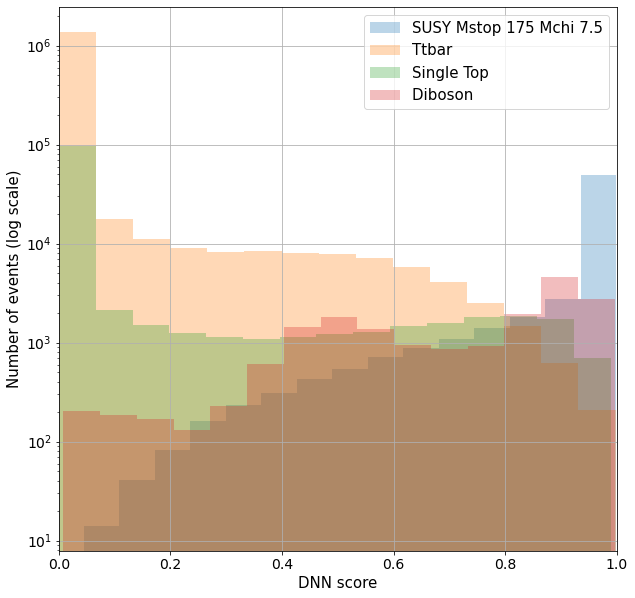

In [24]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(si_pred, bins=15, alpha=0.3, label='SUSY Mstop 175 Mchi 7.5')
plt.hist(tt_pred, bins=15, alpha=0.3, label='Ttbar')
plt.hist(st_pred, bins=15, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=15, alpha=0.3, label='Diboson ')
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)

In [18]:
np.savetxt('Mstop_190_mchi_7_5_SUSY_pred.txt', si_pred)
np.savetxt('Mstop_190_mchi_7_5_tt_pred.txt'  , tt_pred)
np.savetxt('Mstop_190_mchi_7_5_st_pred.txt'  , st_pred)
np.savetxt('Mstop_190_mchi_7_5_sat_pred.txt' , sat_pred)
np.savetxt('Mstop_190_mchi_7_5_vv_pred.txt'  , vv_pred)

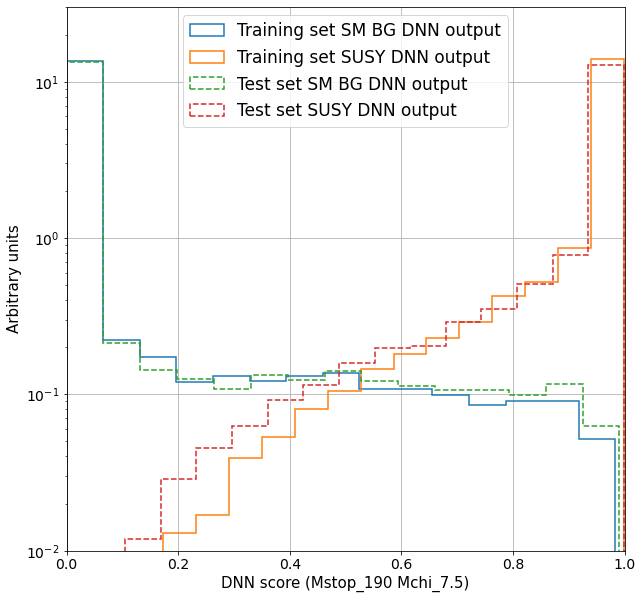

In [33]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=15, label='Training set SM BG DNN output', histtype='step', linestyle='solid', linewidth=1.5, density=True)
plt.hist(y_pred_train[y_train == 1], bins=15, label='Training set SUSY DNN output', histtype='step' , linestyle='solid', linewidth=1.5, density=True)
plt.hist(y_pred_test[y_test == 0], bins=15, label='Test set SM BG DNN output', histtype='step' , linestyle='dashed', linewidth=1.5, density=True)
plt.hist(y_pred_test[y_test == 1], bins=15, label='Test set SUSY DNN output ', histtype='step' , linestyle='dashed', linewidth=1.5, density=True)

plt.yscale('log')
plt.ylim(0.01, 30)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_190 Mchi_7.5)', fontsize=15)
plt.ylabel('Arbitrary units', fontsize=15)
plt.grid()
plt.legend(loc='upper center', fontsize=17)